In [1]:
%matplotlib inline

# Neural Transfer Using PyTorch
=============================


**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_
 
**Edited by**: `Winston Herring <https://github.com/winston6>`_

Introduction
------------

This tutorial explains how to implement the `Neural-Style algorithm <https://arxiv.org/abs/1508.06576>`__
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input 
to resemble the content of the content-image and the artistic style of the style-image.

 
![Title](images/42c9ab8b14fca86f2aa18d1482cb4863.jpg)


Underlying Principle
--------------------

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

Importing Packages and Selecting a Device
-----------------------------------------
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)
![Titile](images/屏幕截图1.png)
对以上内容的理解：
![title](images/webwxgetmsgimg.jpeg)


In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models


import copy

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    `dancing.jpg <https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.
![Title](images\屏幕截图_1.png)


In [4]:
# 想要的输出图像尺寸
imsize = 512 if torch.cuda.is_available() else 128  # 如果没有 GPU 则使用小尺寸
# print(imsize) #128

loader = transforms.Compose([
    transforms.Resize(imsize),  # 缩放图像
    transforms.ToTensor()])  # 将其转化为 torch 张量

#定义图形加载函数
def image_loader(image_name):
    image = Image.open(image_name)
    # print(image) # mode=RGB size=650x650
    image = Variable(loader(image))
    # print(image.size()) # torch.Size([3, 128, 128])
    # 由于神经网络输入的需要, 添加 batch 的维度
    image = image.unsqueeze(0)
    # print(image.size()) # torch.Size([1, 3, 128, 128])
    return image

style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/dancing.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

## Display image
Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.

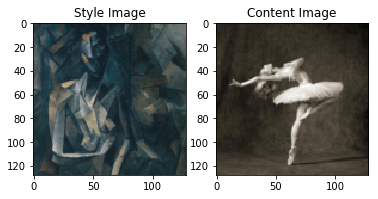

In [5]:
unloader = transforms.ToPILImage()  # 转回 PIL 图像

plt.ion() # 打开交互模式

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # 克隆是为了不改变它
    image = image.view(3, imsize, imsize)  # 移除 batch 维度
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 暂停一会, 让绘图更新

plt.subplot(121)
imshow(style_img.data, title='Style Image')

plt.subplot(122)
imshow(content_img.data, title='Content Image')

In [6]:
# plt.figure?

Loss Functions
--------------
### Content Loss

![Title](images/屏幕截图.png)





In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 我们会从所使用的树中“分离”目标内容
        self.target = target.detach() * weight
        # 动态地计算梯度: 它是个状态值, 不是变量.
        # 否则评价指标的前向方法会抛出错误.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Note:

   **Important detail**: although this module is named ``ContentLoss``, it
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss function, you have to create a PyTorch autograd function 
   to recompute/implement the gradient manually in the ``backward``
   method.



### Style Loss

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.
![title](images/13:57:13.png)

#### 计算克矩阵： 

In [8]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b= K 特征映射的数量,其实就是通道的个数
        # (c,d)= 一个特征映射的维度 (N=c*d)

        # 将每个通道的内容转变为1维的向量
        features = input.view(a * b, c * d)  # 将 F_XL 转换为 \hat F_XL

        G = torch.mm(features, features.t())  # 计算克产物 (gram product)

        # 我们用除以每个特征映射元素数量的方法
            # 标准化克矩阵 (gram matrix) 的值
        return G.div(a * b * c * d)


Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.

<span class="burk">Gram Marix必须被标准化，因为特征映射的维度 N 越长, 则克矩阵 (gram matrix) 的值越大。在梯度下降过程中第一层 (在池化层之前) 的损失计算就会过于重要. 我们当然不希望这样, 因为我们感兴趣的风格特征都在最深的那些层!</span>

#### 定义风格损失
Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Importing the Model
-------------------

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.

PyTorch对 VGG 的实现模块分为两个子 Sequential 模块: features (包括卷积和池化层) 和 classifier (包括全连接层). 我们只对 features 感兴趣:


In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [11]:
# 希望计算风格/内容损失的层 :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    '''
    调用函数：
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
            style_img, content_img, style_weight, content_weight)
    
    参数解释：
    cnn = models.vgg19(pretrained=True).features.to(device).eval() # 采用预训练模型VGG网络
    style_img = image_loader("images/picasso.jpg").type(dtype)
    content_img = image_loader("images/dancing.jpg").type(dtype)
    style_weight=1000
    content_weight=1
    '''
    cnn = copy.deepcopy(cnn)

    # 仅为了有一个可迭代的列表 内容/风格 损失
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # 新建的 Sequential 网络模块
    gram = GramMatrix()  # 我们需要一个克模块 (gram module) 来计算风格目标

    # 可能的话将这些模块移到 GPU 上:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # 加内容损失:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # 加风格损失:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # 加内容损失:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # 加风格损失:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

In [ ]:
# 测试：
content_layers_default = ['conv_6']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layers=content_layers_default
style_layers=style_layers_default
style_weight=1000
content_weight=1
cnn = copy.deepcopy(cnn)

# 仅为了有一个可迭代的列表 内容/风格 损失
content_losses = []
style_losses = []

model = nn.Sequential()  # 新建的 Sequential 网络模块
gram = GramMatrix()  # 我们需要一个克模块 (gram module) 来计算风格目标
i=1
for layer in list(cnn):
    # print(layer)
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        # print(name)
        model.add_module(name, layer)
        if name in content_layers: # content_layers_default = ['conv_4']
            # 加内容损失: 
            target = model(content_img).clone()
            print(target)
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers: # style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
            # 加风格损失:
            target_feature = model(style_img).clone()
            target_feature_gram = gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)
    if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # 加内容损失:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # 加风格损失:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***
    i += 1
    
print('model:\n',model,'\n style_losses:\n', style_losses, '\n content_losses: \n',content_losses)
    

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




### Input Image
Next, we select the input image. You can use a copy of the content image
or white noise.




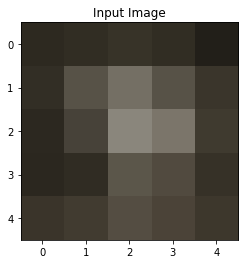

In [13]:
input_img = content_img.clone()
# 如果你想用白噪声做输入, 请取消下面的注释行:
#input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# 在绘图中加入原始的输入图像:
plt.figure()
imshow(input_img.data, title='Input Image')

Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [14]:
def get_input_param_optimizer(input_img):
    # 这行显示了输入是一个需要梯度计算的参数
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the modul and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [15]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    '''
    调用函数：
    output = run_style_transfer(cnn, content_img, style_img, input_img)
    参数解释：
    cnn = models.vgg19(pretrained=True).features.to(device).eval() # 采用预训练模型VGG网络
    content_img = image_loader("images/dancing.jpg").type(dtype)
    style_img = image_loader("images/picasso.jpg").type(dtype)
    input_img = content_img.clone()
    '''
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    
    #调用得到风格模型与风格损失的函数
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 校正更新后的输入图像值
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后一次的校正...
    input_param.data.clamp_(0, 1)

    return input_param.data

Finally, we can run the algorithm.




In [16]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small at /pytorch/aten/src/THNN/generic/SpatialDilatedMaxPooling.c:67